In [78]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [79]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [80]:
NUM_CLASSES = 5

# 学習データ読み込み

In [81]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [82]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [84]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [85]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [86]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [87]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [88]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
31/32 [============================>.] - ETA: 0s - loss: 1.6082 - accuracy: 0.2399
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 2s 19ms/step - loss: 1.6066 - accuracy: 0.2418 - val_loss: 1.5516 - val_accuracy: 0.2953
Epoch 2/1000
17/32 [==============>...............] - ETA: 0s - loss: 1.5323 - accuracy: 0.2983
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 7ms/step - loss: 1.5143 - accuracy: 0.3179 - val_loss: 1.4493 - val_accuracy: 0.5384
Epoch 3/1000
31/32 [============================>.] - ETA: 0s - loss: 1.4367 - accuracy: 0.3916
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 7ms/step - loss: 1.4382 - accuracy: 0.3918 - val_loss: 1.3583 - val_accuracy: 0.5585
Epoch 4/1000
29/32 [==========================>...] - ETA: 0s - loss: 1.3887 - accuracy: 0.4318


In [89]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 6ms/step - loss: 0.3138 - accuracy: 0.9627


In [90]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [91]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 79ms/step
[0.19365169 0.03065359 0.01240549 0.00143342 0.7618558 ]
4


# 混同行列

42/42 [==============================] - 0s 2ms/step


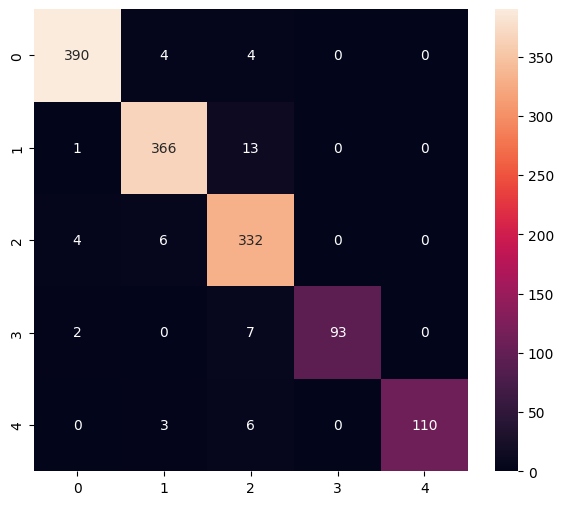

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       398
           1       0.97      0.96      0.96       380
           2       0.92      0.97      0.94       342
           3       1.00      0.91      0.95       102
           4       1.00      0.92      0.96       119

    accuracy                           0.96      1341
   macro avg       0.97      0.95      0.96      1341
weighted avg       0.96      0.96      0.96      1341



In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [93]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [94]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-05-23 23:16:44.961784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,42]
	 [[{{node input_5}}]]
2024-05-23 23:16:45.138961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-05-23 23:16:45.167824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,42]
	 [[{{node input_5}}]]
2024-05-23 23:1

INFO:tensorflow:Assets written to: /tmp/tmp8agglhk6/assets


INFO:tensorflow:Assets written to: /tmp/tmp8agglhk6/assets
2024-05-23 23:16:46.895145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-23 23:16:46.895185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-23 23:16:46.895448: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8agglhk6
2024-05-23 23:16:46.897086: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-23 23:16:46.897119: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8agglhk6
2024-05-23 23:16:46.906558: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-23 23:16:46.966950: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp8agglhk6
2024-05-23 23:16:46.986248: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

6652

# 推論テスト

In [95]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [96]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [97]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [98]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.13 ms, sys: 68 µs, total: 1.2 ms
Wall time: 1.31 ms


In [99]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.19365169 0.03065361 0.0124055  0.00143342 0.7618558 ]
4
